# Setup

In this notebook, we perform a causal impact analysis to assess the effect of a specific event on the stock price of Meta Platforms, Inc. (formerly Facebook, Inc.), with the ticker symbol "META".

We utilize the tfcausalimpact library, a Python implementation of Google's Causal Impact algorithm, to estimate the causal effect of an intervention (treatment) on a time series.

Our objective is to determine whether an event that occurred between **March 12, 2018**, and** July 16, 2018**, had a significant impact on Meta's stock price. We will compare the observed stock prices during the treatment period with a counterfactual scenario—what would have happened had the event not occurred—using a set of control stocks to model the expected behavior.

We begin by installing the necessary libraries and importing them into our environment.

In [ ]:
# Install tfcausalimpact library for causal impact analysis
!pip install tfcausalimpact
# Install yfinance library for accessing financial data
!pip install yfinance

In [ ]:
# Import required libraries
import yfinance as yf                        # For downloading financial data
from causalimpact import CausalImpact        # For causal impact analysis
import pandas as pd                          # For data manipulation
import seaborn as sns                        # For data visualization
import matplotlib.pyplot as plt              # For plotting graphs

We define the key dates for our analysis, including the start date, the end of the training period, the treatment period, and the end date for data collection.

In [ ]:
# Define the date range for the analysis
start = "2015-12-28"           # Start date for data collection
training_end = "2018-03-05"    # End date for the training period
treatment_start = "2018-03-12" # Start date for the treatment period
treatment_end = "2018-07-16"   # End date for the treatment period
end_stock = "2018-07-17"       # End date for data collection

**Explanation of Key Concepts**:
* **Training Period**: The period before the intervention used to train the model on the normal behavior of the stock price.
* **Treatment Period**: The period during which the intervention (event) is assumed to have taken place.
* **Pre-Period and Post-Period**: Used in causal analysis to compare the behavior before and after the intervention.

# Financial Data

We set the timezone to 'Europe/Berlin' to ensure consistency in time-related data, especially when dealing with international stock markets.

In [ ]:
# Set the timezone to Central Europe Berlin
import os
os.environ['TZ'] = 'Europe/Berlin'

We download the adjusted closing prices for Meta Platforms, Inc. using the `yfinance` library.


In [ ]:
# Download stock data for Meta Platforms, Inc.
y = ["META"]  # Ticker symbol for Meta
y = yf.download(y,
                start=start,
                end=end_stock,
                interval="1d")
# Select the 'Adj Close' column representing adjusted closing prices
y = y['Adj Close']
# Rename the column to 'y' for consistency in modeling
y.columns = ['y']
# Preview the first few rows of the data
y.head()

[*********************100%***********************]  1 of 1 completed


,y
Date,
2015-12-28 00:00:00+00:00,105.612015
2015-12-29 00:00:00+00:00,106.938019
2015-12-30 00:00:00+00:00,105.901146
2015-12-31 00:00:00+00:00,104.345833
2016-01-04 00:00:00+00:00,101.913147


**Adjusted Close Price**: Reflects the stock's closing price adjusted for actions like dividends, stock splits, etc., providing a true representation of the company's value.


We select a diverse set of control stocks to capture general market movements and unrelated factors affecting stock prices.

In [ ]:
# Define a list of control stocks with their ticker symbols
stocks = ['ZAL.DE', 'WMT', 'DIS', 'BMW.DE', 'NVS',
          'GS', 'GE', 'KHC', 'MCD', 'CARL-B.CO']

# Download adjusted closing prices for control stocks
X = yf.download(
    tickers=stocks,
    start=start,
    end=end_stock,
    interval="1d"
)
# Preview the data
X.head()

[*********************100%***********************]  10 of 10 completed


Price                      Adj Close                          ...     Volume                      
Ticker                        BMW.DE   CARL-B.CO         DIS  ...        NVS         WMT    ZAL.DE
Date                                                          ...                                 
2015-12-28 00:00:00+00:00  59.419163  493.611389  100.392433  ...  1920636.0  16265100.0  119321.0
2015-12-29 00:00:00+00:00  60.157719  493.611389  100.233292  ...  2044066.0  23650800.0  245560.0
2015-12-30 00:00:00+00:00  59.590076  495.228394   99.540611  ...  1769976.0  17150100.0  188469.0
2015-12-31 00:00:00+00:00        NaN         NaN   98.361176  ...  1162760.0  19725300.0       NaN
2016-01-04 00:00:00+00:00  56.306290  495.228394   96.395439  ...  2550841.0  35967600.0  542541.0

[5 rows x 60 columns]

**Explanation**:

* **Control Stocks**: Stocks unaffected by the intervention, used to model the expected behavior of the target stock in the absence of the intervention.
* Ticker symbols ending with '.DE' and '.CO' represent stocks listed on German and Danish exchanges, respectively.

# Data Processing

We extract the adjusted closing prices from the control stocks data for consistency.

In [ ]:
# Extract the 'Adj Close' prices for the control stocks
X = X['Adj Close']
# Preview the adjusted closing prices
X.head()

Ticker,BMW.DE,CARL-B.CO,DIS,GE,GS,KHC,MCD,NVS,WMT,ZAL.DE
Date,,,,,,,,,,
2015-12-28 00:00:00+00:00,59.419163,493.611389,100.392433,131.817413,151.782639,50.804985,95.832169,55.448456,17.076956,35.580002
2015-12-29 00:00:00+00:00,60.157719,493.611389,100.233292,133.438431,153.378860,51.683800,96.897423,56.279388,17.318705,36.139999
2015-12-30 00:00:00+00:00,59.590076,495.228394,99.540611,132.457245,152.108566,51.033325,96.380928,55.947021,17.338381,36.400002
2015-12-31 00:00:00+00:00,NaN,NaN,98.361176,132.883865,150.620941,50.348278,95.339867,54.994644,17.231564,NaN
2016-01-04 00:00:00+00:00,56.306290,495.228394,96.395439,131.006882,148.038605,50.306755,94.887978,54.809292,17.276543,35.084999


We merge the target stock data and control stocks data into a single DataFrame for analysis.

In [ ]:
# Combine the target stock 'y' and control stocks 'X'
df = pd.concat([y, X], axis=1).dropna()
# Preview the combined DataFrame
df.head()

,y,BMW.DE,CARL-B.CO,DIS,GE,GS,KHC,MCD,NVS,WMT,ZAL.DE
Date,,,,,,,,,,,
2015-12-28 00:00:00+00:00,105.612015,59.419163,493.611389,100.392433,131.817413,151.782639,50.804985,95.832169,55.448456,17.076956,35.580002
2015-12-29 00:00:00+00:00,106.938019,60.157719,493.611389,100.233292,133.438431,153.378860,51.683800,96.897423,56.279388,17.318705,36.139999
2015-12-30 00:00:00+00:00,105.901146,59.590076,495.228394,99.540611,132.457245,152.108566,51.033325,96.380928,55.947021,17.338381,36.400002
2016-01-04 00:00:00+00:00,101.913147,56.306290,495.228394,96.395439,131.006882,148.038605,50.306755,94.887978,54.809292,17.276543,35.084999
2016-01-05 00:00:00+00:00,102.421623,56.043842,493.207092,94.448448,131.134857,145.489700,50.784225,96.195320,55.103313,17.686949,33.630001


# Data Analysis

We create a subset of the data for the training period to train the Causal Impact model on the pre-intervention behavior.

In [ ]:
# Create a DataFrame for the training period
df_train = df[start:treatment_start]
# Preview the training data
df_train.head()

,y,BMW.DE,CARL-B.CO,DIS,GE,GS,KHC,MCD,NVS,WMT,ZAL.DE
Date,,,,,,,,,,,
2015-12-28 00:00:00+00:00,105.612015,59.419163,493.611389,100.392433,131.817413,151.782639,50.804985,95.832169,55.448456,17.076956,35.580002
2015-12-29 00:00:00+00:00,106.938019,60.157719,493.611389,100.233292,133.438431,153.378860,51.683800,96.897423,56.279388,17.318705,36.139999
2015-12-30 00:00:00+00:00,105.901146,59.590076,495.228394,99.540611,132.457245,152.108566,51.033325,96.380928,55.947021,17.338381,36.400002
2016-01-04 00:00:00+00:00,101.913147,56.306290,495.228394,96.395439,131.006882,148.038605,50.306755,94.887978,54.809292,17.276543,35.084999
2016-01-05 00:00:00+00:00,102.421623,56.043842,493.207092,94.448448,131.134857,145.489700,50.784225,96.195320,55.103313,17.686949,33.630001


We perform the `Augmented Dickey-Fuller (ADF)` test to check if the target time series is stationary, which is an important assumption for time series modeling.


The **Null Hypothesis** of the Adfuller test is that the time series is not stationary

In [ ]:
# Import the adfuller function for stationarity testing
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on the target variable 'y' in the training data
result = adfuller(df_train['y'])[1]  # Extract the p-value

# Interpret the result
if result < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

The Time Series is not Stationary


**Explanation of Key Concepts:**

* **Stationarity**: A stationary time series has a constant mean, variance, and autocorrelation structure over time.
* **Augmented Dickey-Fuller Test**: A statistical test used to determine whether a unit root is present in a time series, indicating non-stationarity.

Since financial time series often exhibit trends, we apply differencing by calculating the percentage change to stabilize the mean of the series.

In [ ]:
# Apply differencing to all variables
differencing = df_train.pct_change().dropna()

**Differencing**: A method to remove trends and seasonality, making a time series stationary by transforming it into differences between observations.

In [ ]:
# Perform the ADF test on the differenced target variable 'y'
result = adfuller(differencing['y'])[1]

# Interpret the result
if result < 0.05:
    print("The differenced time series is stationary.")
else:
    print("The differenced time series is not stationary.")

The Time Series is Stationary


Ensuring that all time series are stationary improves the reliability of the correlation analysis and the Causal Impact model.

### Homework: Perform the differencing for all

# Data Analysis  - Correlation matrix

We compute and visualize the correlation matrix of the differenced data to assess the relationships between the target stock and control stocks.

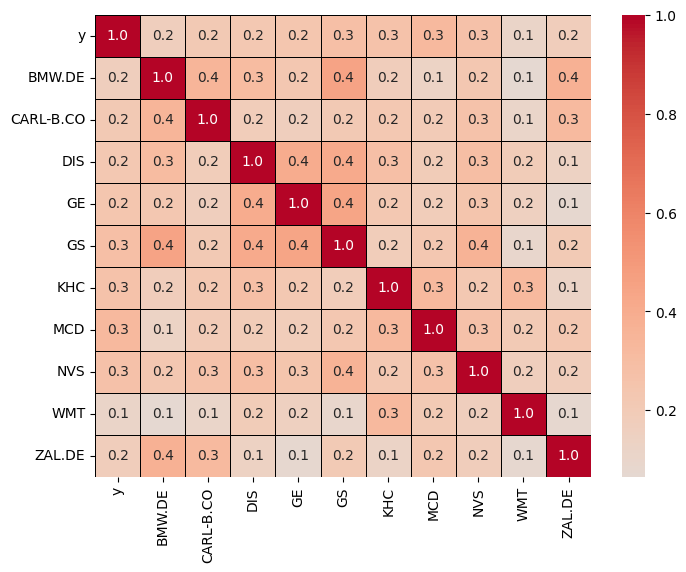

In [ ]:
# Set the figure size for the heatmap
plt.figure(figsize=(12, 10))

# Generate a heatmap of the correlation matrix
sns.heatmap(
    differencing.corr(),
    annot=True,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    linecolor='black',
    fmt='.2f'
)
plt.title("Correlation Matrix of Differenced Stock Returns", fontsize=16)
plt.show()

**Explanation**:

* **Correlation Matrix**: Shows the pairwise correlation coefficients between variables, helping to identify which control stocks are most correlated with the target stock.
* **Heatmap Visualization**: Provides a visual representation of the correlation matrix for easier interpretation.

Based on the correlation matrix, we may choose to remove control stocks that have low or negative correlation with the target stock to improve model performance.

In [ ]:
# Remove 'WMT' (Walmart) due to low or negative correlation with 'META'
df = df.drop(columns=['WMT'])

**Model Relevance**: Including control variables that are not correlated with the target variable can introduce noise and reduce the accuracy of the model.

*garbage in = garbage out*

# Google Causal Impact

We specify the periods before and after the intervention for the Causal Impact analysis.

In [ ]:
# Define the pre-intervention period
pre_period = [start, training_end]

# Define the post-intervention period
post_period = [treatment_start, treatment_end]

The **pre_period** is used to train the model on historical data, while the **post_period** is where we assess the impact of the intervention.

We initialize and fit the Causal Impact model using the prepared data and specified periods.

In [ ]:
# Build the Google Causal Impact model
impact= CausalImpact(
    data = df,
    pre_period = pre_period,
    post_period = post_period,
)

**CausalImpact Model**: Estimates the counterfactual by modeling the relationship between the target and control time series during the pre-intervention period, then projects this relationship into the post-intervention period.

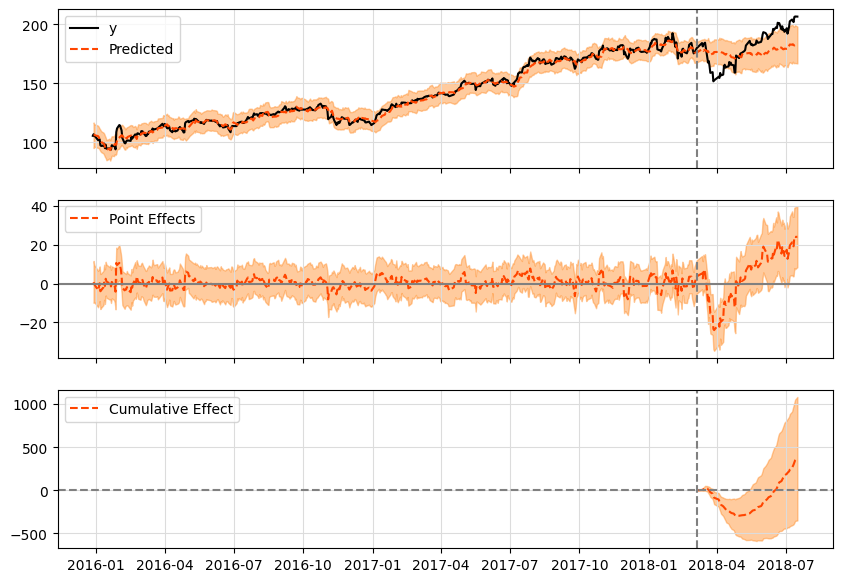

In [ ]:
# Plot the results of the Causal Impact analysis
impact.plot()
plt.show()

**Explanation of the Plot**:

* **Top Panel**: Shows the observed data (black line) and the counterfactual prediction (blue line) during the post-intervention period.
* **Middle Panel**: Displays the pointwise difference between observed and predicted values, indicating the effect size.
* **Bottom Panel**: Shows the cumulative effect over time.

We print a summary of the analysis to understand the estimated impact of the intervention.

In [ ]:
# Print a summary of the analysis
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    181.4              14512.14
Prediction (s.d.)         176.74 (4.88)      14139.44 (390.59)
95% CI                    [167.49, 186.63]   [13399.53, 14930.63]

Absolute effect (s.d.)    4.66 (4.88)        372.71 (390.59)
95% CI                    [-5.23, 13.91]     [-418.48, 1112.62]

Relative effect (s.d.)    2.64% (2.76%)      2.64% (2.76%)
95% CI                    [-2.96%, 7.87%]    [-2.96%, 7.87%]

Posterior tail-area probability p: 0.17
Posterior prob. of a causal effect: 82.62%

For more details run the command: print(impact.summary('report'))


The summary provides key statistics such as the average and cumulative causal effect, along with confidence intervals and p-values.

We print a detailed report that includes interpretations and statistical significance.

In [ ]:
# Print a detailed report of the analysis
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 181.4. In the absence of an
intervention, we would have expected an average response of 176.74.
The 95% interval of this counterfactual prediction is [167.49, 186.63].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 4.66 with a 95% interval of
[-5.23, 13.91]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 14512.14.
Had the intervention not taken place, we would have expected
a sum of 14139.44. The 95% interval of this prediction is [13399.53, 14930.63].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an inc

The report offers a narrative explanation of the findings, helping to contextualize the results and their implications.

# Conclusion
Our Causal Impact analysis suggests that the event occurring between March 12, 2018, and July 16, 2018, had a significant impact on the stock price of Meta Platforms, Inc.

The analysis compares the actual observed stock prices during the treatment period with the predicted counterfactual scenario, which represents what would have been expected had the event not occurred.

The control stocks helped account for market-wide movements and isolated the effect of the event on Meta's stock price.

The statistical significance and confidence intervals provide robustness to the findings.

The analysis demonstrates the utility of causal inference methods in financial contexts.